# Heart Attack Data Analysis

Heart disease is a leading cause of death in the United States, but it can treated if detected early and the individual can regain health. The ability to predict whether an individual has heart disease based on certain health factors is therefore critical for the detection and treatment of heart disease, and has the potential to save countless lives.

This project aims to develop a supervised machine learning model which can be used to carry out the binary classification task of predicting whether an individual has heart disease.

The dataset used in this project is the Heart Disease dataset from the UC Irving Machine Learning Repository (Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988, June 30). UCI Machine Learning Repository. Archive.ics.uci.edu. https://archive.ics.uci.edu/dataset/45/heart+disease)

This dataset contains 303 observations and 14 features. Each observation is an individual, and the features are various health factors about the individual.

The following features are included:
- `age` - the age of the individual in years
- `sex` - the sex of the individual (0 = female; 1 = male)
- `cp` - the chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)
- `trestbps` - resting blood pressure
- `chol` - cholesterol
- `fbs` - fasting blood sugar
- `restecg` - resting electrocardiographic results (0 = normal; 1 = ST-T wave abnormality; 2 = ventricular hypertrophy)
- `thalach` - maximum heart rate achieved
- `exang` - exercise induced angina
- `oldpeak` - ST depression induced by exercise relative to rest
- `slope` - slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping)
- `ca` - number of major vessels colored by flourosopy
- `thal` - thallium stress test results (3 = normal; 6 = fixed defect; 7 = reversable defect)
- `num` - diagnosis of heart disease

In this project, I train, tune and evaluate three machine learning models, a logistic regression model, a random forest model, and a support vector machine model. I then select the best model to be used in an application which predicts whether an individual has heart diesease, which can be used for the detection and treatment of heart disease in new patient.

## Loading Data

We'll begin the analysis by importing modules and loading the data. The data is saved locally in the `./data/processed.cleveland.data` file.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

In [2]:
heart_attack = pd.read_csv('data/processed.cleveland.data', header=None)
print(heart_attack.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       303 non-null    float64
 1   1       303 non-null    float64
 2   2       303 non-null    float64
 3   3       303 non-null    float64
 4   4       303 non-null    float64
 5   5       303 non-null    float64
 6   6       303 non-null    float64
 7   7       303 non-null    float64
 8   8       303 non-null    float64
 9   9       303 non-null    float64
 10  10      303 non-null    float64
 11  11      303 non-null    object 
 12  12      303 non-null    object 
 13  13      303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB
None


## Cleaning Data

Before we begin our exploratory data analysis and data modeling, we'll inspect the data and clean it up.

First we'll assign names to each of the columns. Then we'll look for missing values and drop them. From there, we'll re-cast some of the data types, convert categorical variables to binary variables, and rescale continuous variables to improve model performance.

We will also convert the target variable from multiclass to binary, collapsing multiple classes which indicate heart disease into a single class.

In [3]:
# renaming columns
heart_attack.columns = [
    'age', # labeled as 'age' in the source docs
    'sex', # sex
    'chest_pain_type', # cp
    'resting_blood_pressure', # trestbps
    'cholesterol', # chol
    'fasting_blood_sugar', # fbs
    'rest_ecg', # restecg
    'max_heart_rate_achieved', # thalach
    'exercise_induced_angina', # exang
    'previous_peak', # oldpeak
    'slope', # slope
    'major_vessels', # ca
    'thal_rate', # thal
    'target_multiclass' # num
]

In [4]:
# finding missing values and dropping them
# it looks like missing values are coded as "?" so we'll replace them with None and drop them
nrow_before = heart_attack.shape[0]
# print(heart_attack.isnull().sum())
heart_attack = heart_attack.replace('?', None)
# print(heart_attack.replace('?', None).isnull().sum())
heart_attack = heart_attack.dropna()
nrow_after = heart_attack.shape[0]
print(f'Dropped {nrow_before - nrow_after} rows')
print('Current shape:', heart_attack.shape)

Dropped 6 rows
Current shape: (297, 14)


In [5]:
# casting variable to integers
columns_to_cast_to_int = [
    'sex',
    'chest_pain_type',
    'fasting_blood_sugar',
    'rest_ecg',
    'exercise_induced_angina',
    'slope',
    'major_vessels',
    'thal_rate',
    'target_multiclass'
]

for column in columns_to_cast_to_int:
    # need to cast to float first because some values are strings and some are ints
    # print(f'Casting {column} to int')
    heart_attack[column] = heart_attack[column].astype(float).astype(int)

In [6]:

# converting categorical variables to binary
# chest pain types - converting categorical to binary
# we can omit the asymptomatic column since it's redundant
heart_attack['typical_angina'] = (heart_attack['chest_pain_type'] == 1).astype(int)
heart_attack['atypical_angina'] = (heart_attack['chest_pain_type'] == 2).astype(int)
heart_attack['non_anginal_pain'] = (heart_attack['chest_pain_type'] == 4).astype(int)
# heart_attack['asymptomatic'] = (heart_attack['chest_pain_type'] == 4).astype(int)

# resting ecg - converting categorical to binary
# we can omit the ventricular_hypertrophy column since it's redundant
heart_attack['resting_normal'] = (heart_attack['rest_ecg'] == 0).astype(int)
heart_attack['stt_wave_abnormality'] = (heart_attack['rest_ecg'] == 1).astype(int)
# heart_attack['ventricular_hypertrophy'] = (heart_attack['rest_ecg'] == 2).astype(int)

# slope - converting categorical to binary
# we can omit both the flat and down slope column since they both indicate that the individual is unhealthy and they are redundant with the up_slope column
heart_attack['up_slope'] = (heart_attack['slope'] == 1).astype(int)
# heart_attack['flat_slope'] = (heart_attack['slope'] == 2).astype(int)
# heart_attack['down_slope'] = (heart_attack['slope'] == 2).astype(int)

# thal_rate - converting categorical to binary
# we can omit the reversible and fixed defect columns since they both indicate that the individual is unhealthy and they are redundant with the normal column
heart_attack['normal_thal'] = (heart_attack['thal_rate'] == 3).astype(int)
# heart_attack['reversible_defect'] = (heart_attack['thal_rate'] == 6).astype(int)
# heart_attack['fixed_defect'] = (heart_attack['thal_rate'] == 7).astype(int)

# target - converting multiclass to binary. 0 means no heart disease, anything else means heart disease
heart_attack['target'] = (heart_attack['target_multiclass'] > 0).astype(int)

In [7]:

# rescaling continuous variables
# we will use min-max scaling
columns_to_rescale = [
    'age',
    'resting_blood_pressure',
    'cholesterol',
    'max_heart_rate_achieved',
    'previous_peak'
]

for column in columns_to_rescale:
    # print(f'Rescaling {column}')
    heart_attack[column] = (heart_attack[column] - heart_attack[column].min()) / (heart_attack[column].max() - heart_attack[column].min())

## EDA

Now that we have cleaned the data, we can begin our exploratory data analysis.

The goal of this exploratory data analysis is to better understand patterns in the data. We will inspect distributions of each feature and relationships between variables. This analysis will inform feature selection, feature engineering and additional data cleaning.

First, we'll inspect the first fiew rows to take a glimpse at the data. Then we'll summarize the data to get a better understanding of the distribution of each feature. And finally, we'll create a pairplot and a correlation matrix to better understand how each feature related to one another. If there are any highly correlated predictor variables, we can remove them.

In [8]:
# inpect the first few rows
heart_attack.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,previous_peak,...,thal_rate,target_multiclass,typical_angina,atypical_angina,non_anginal_pain,resting_normal,stt_wave_abnormality,up_slope,normal_thal,target
0,0.708333,1,1,0.481132,0.244292,1,2,0.603053,0,0.370968,...,6,0,1,0,0,0,0,0,0,0
1,0.791667,1,4,0.622642,0.365297,0,2,0.282443,1,0.241935,...,3,2,0,0,1,0,0,0,1,1
2,0.791667,1,4,0.245283,0.235160,0,2,0.442748,1,0.419355,...,7,1,0,0,1,0,0,0,0,1
3,0.166667,1,3,0.339623,0.283105,0,0,0.885496,0,0.564516,...,3,0,0,0,0,1,0,0,1,0
4,0.250000,0,2,0.339623,0.178082,0,2,0.770992,0,0.225806,...,3,0,0,1,0,0,0,1,1,0


In [9]:
# print summary statistics for each column
heart_attack.describe()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,previous_peak,...,thal_rate,target_multiclass,typical_angina,atypical_angina,non_anginal_pain,resting_normal,stt_wave_abnormality,up_slope,normal_thal,target
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,...,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,0.532127,0.676768,3.158249,0.355600,0.277055,0.144781,0.996633,0.599995,0.326599,0.170251,...,4.730640,0.946128,0.077441,0.164983,0.478114,0.494949,0.013468,0.468013,0.552189,0.461279
std,0.188536,0.468500,0.964859,0.167574,0.118716,0.352474,0.994914,0.175126,0.469761,0.188084,...,1.938629,1.234551,0.267741,0.371792,0.500364,0.500818,0.115462,0.499818,0.498108,0.499340
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.395833,0.000000,3.000000,0.245283,0.194064,0.000000,0.000000,0.473282,0.000000,0.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.562500,1.000000,3.000000,0.339623,0.267123,0.000000,1.000000,0.625954,0.000000,0.129032,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.666667,1.000000,4.000000,0.433962,0.342466,0.000000,2.000000,0.725191,1.000000,0.258065,...,7.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,7.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


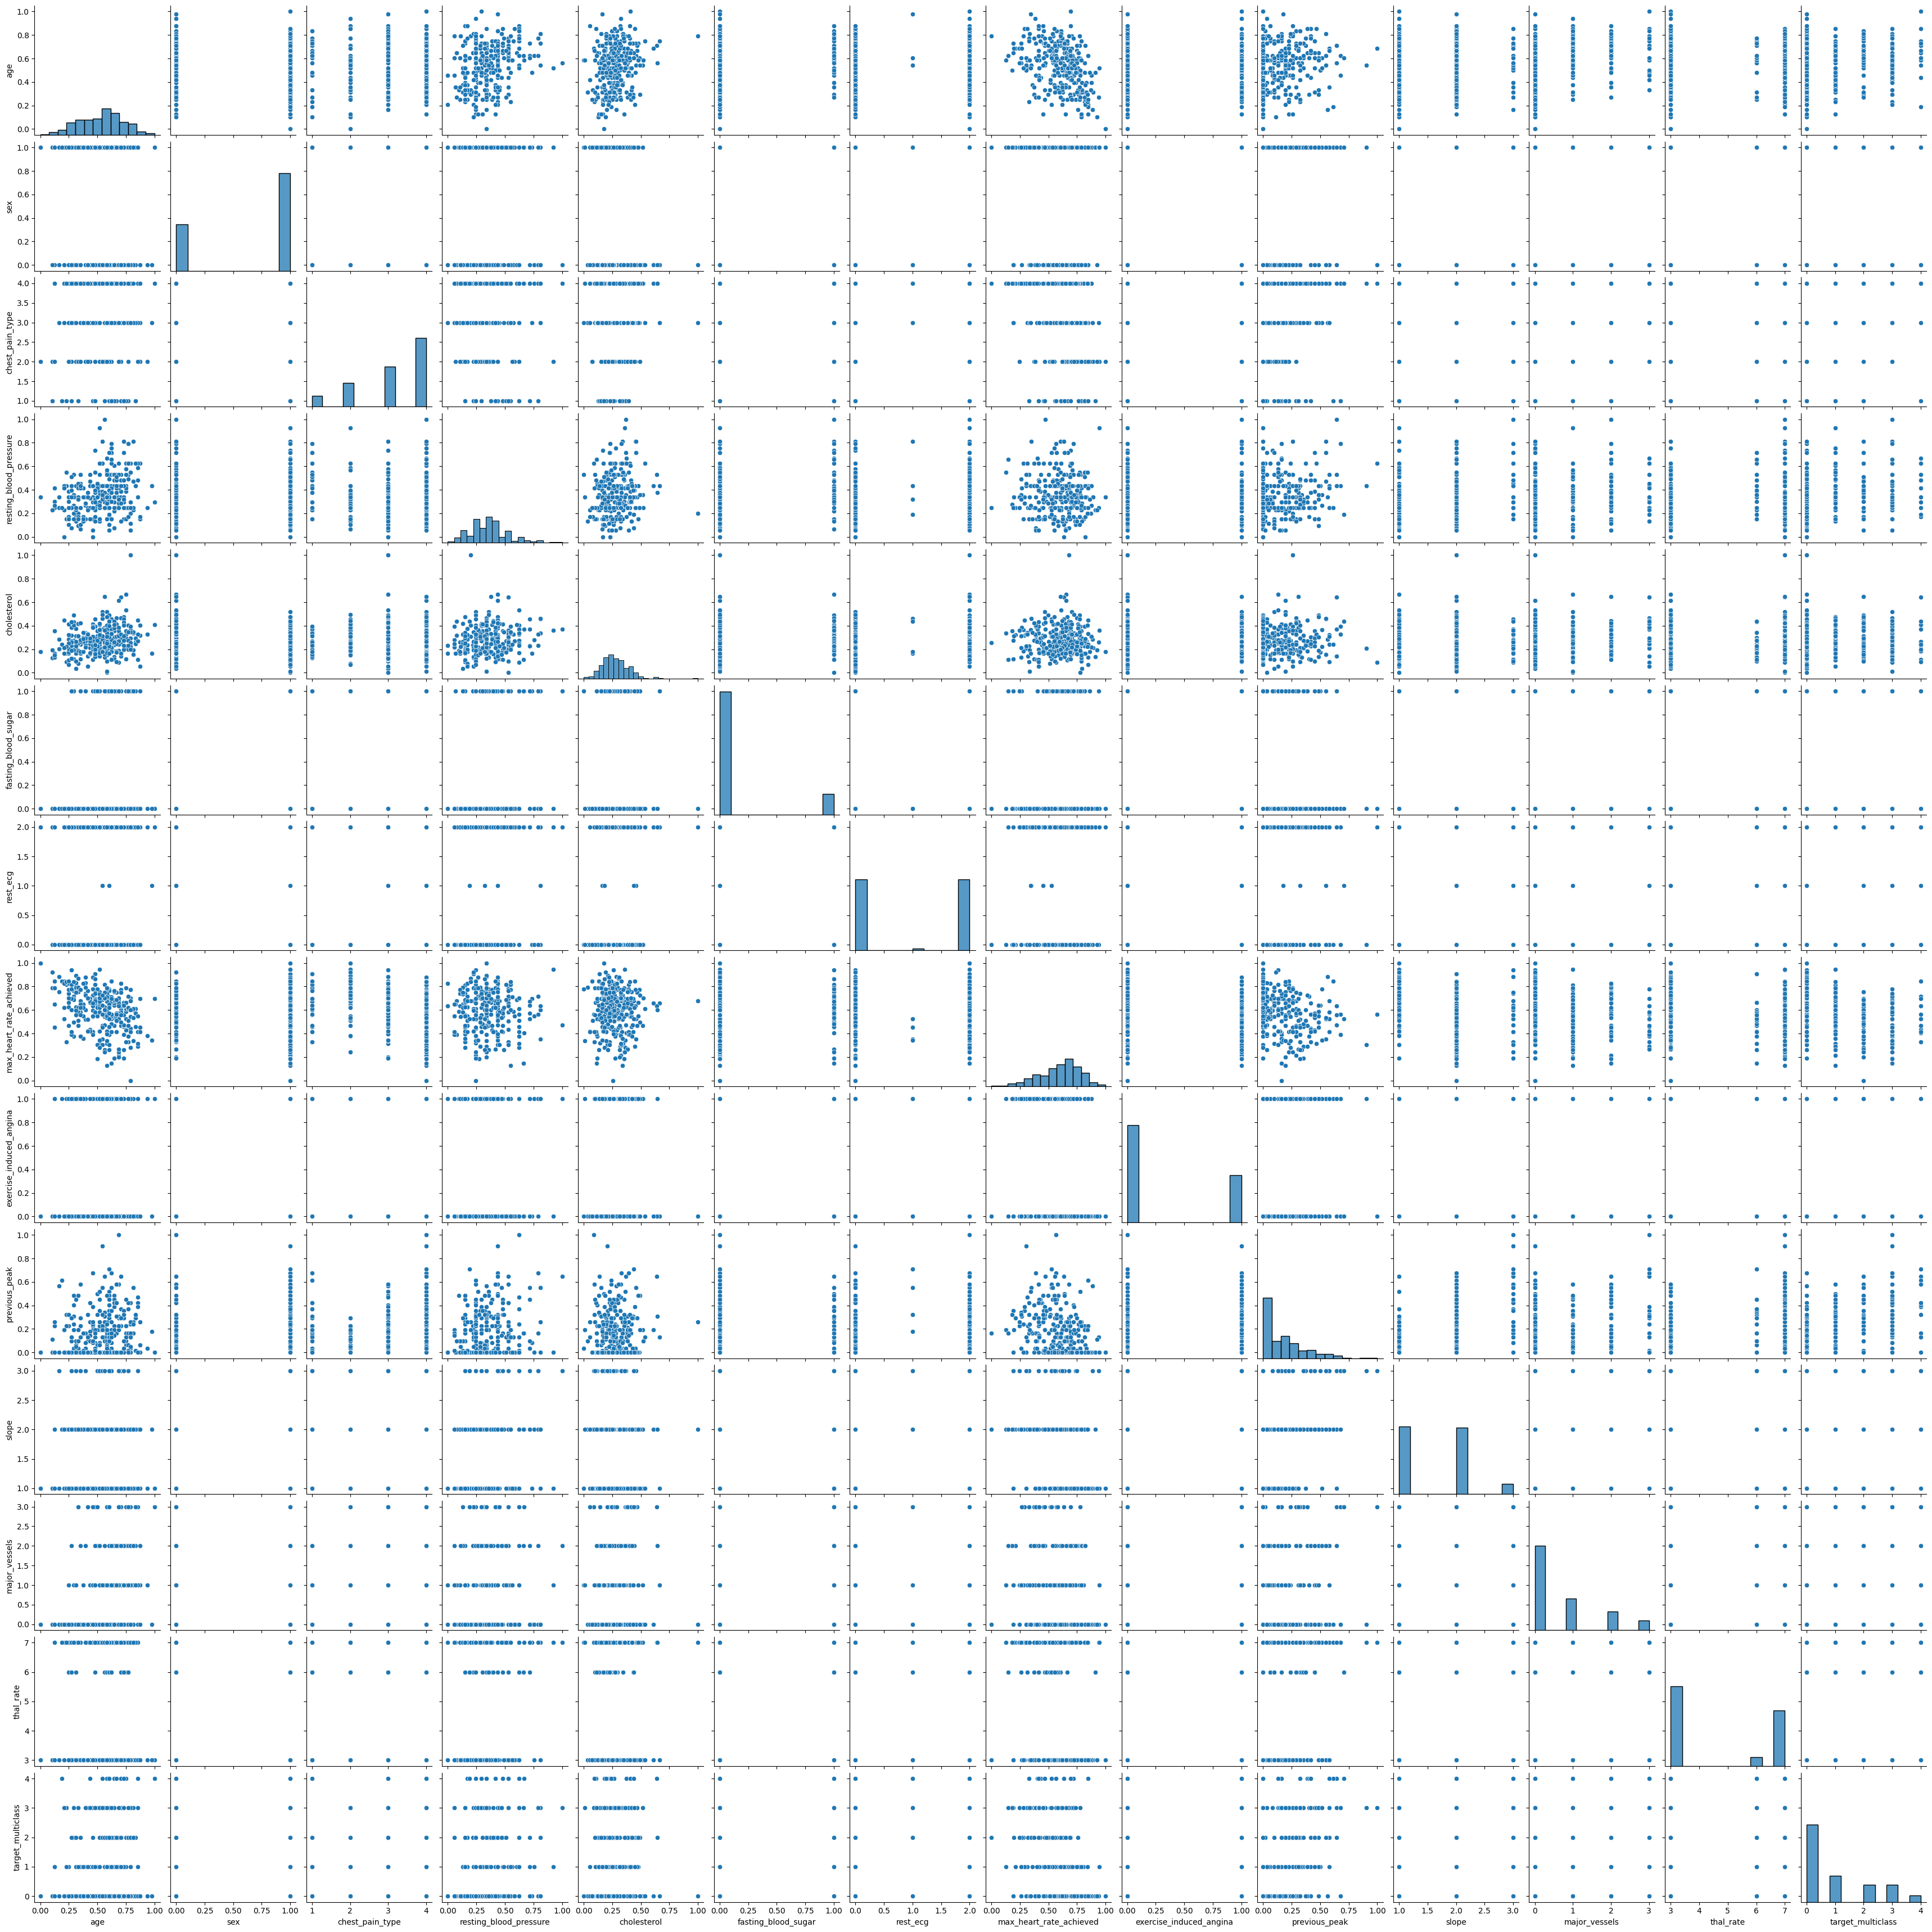

In [10]:
# create a pairplot of all variables
# exclude columns which we created from categorical variables
# some of these aren't in the dataframe, but that's okay
pairplot_columns_to_exclude = [
    'typical_angina',
    'atypical_angina',
    'non_anginal_pain',
    'asymptomatic',
    'resting_normal',
    'stt_wave_abnormality',
    'ventricular_hypertrophy',
    'up_slope',
    'flat_slope',
    'down_slope',
    'normal_thal',
    'reversible_defect',
    'fixed_defect',
    'target',
]

pairplot_columns = [
    column for column in heart_attack.columns if column not in pairplot_columns_to_exclude
]

ax = sns.pairplot(
    heart_attack[pairplot_columns],
    # diag_kind='kde'
)

# ax.savefig('plots/pairplot.png')

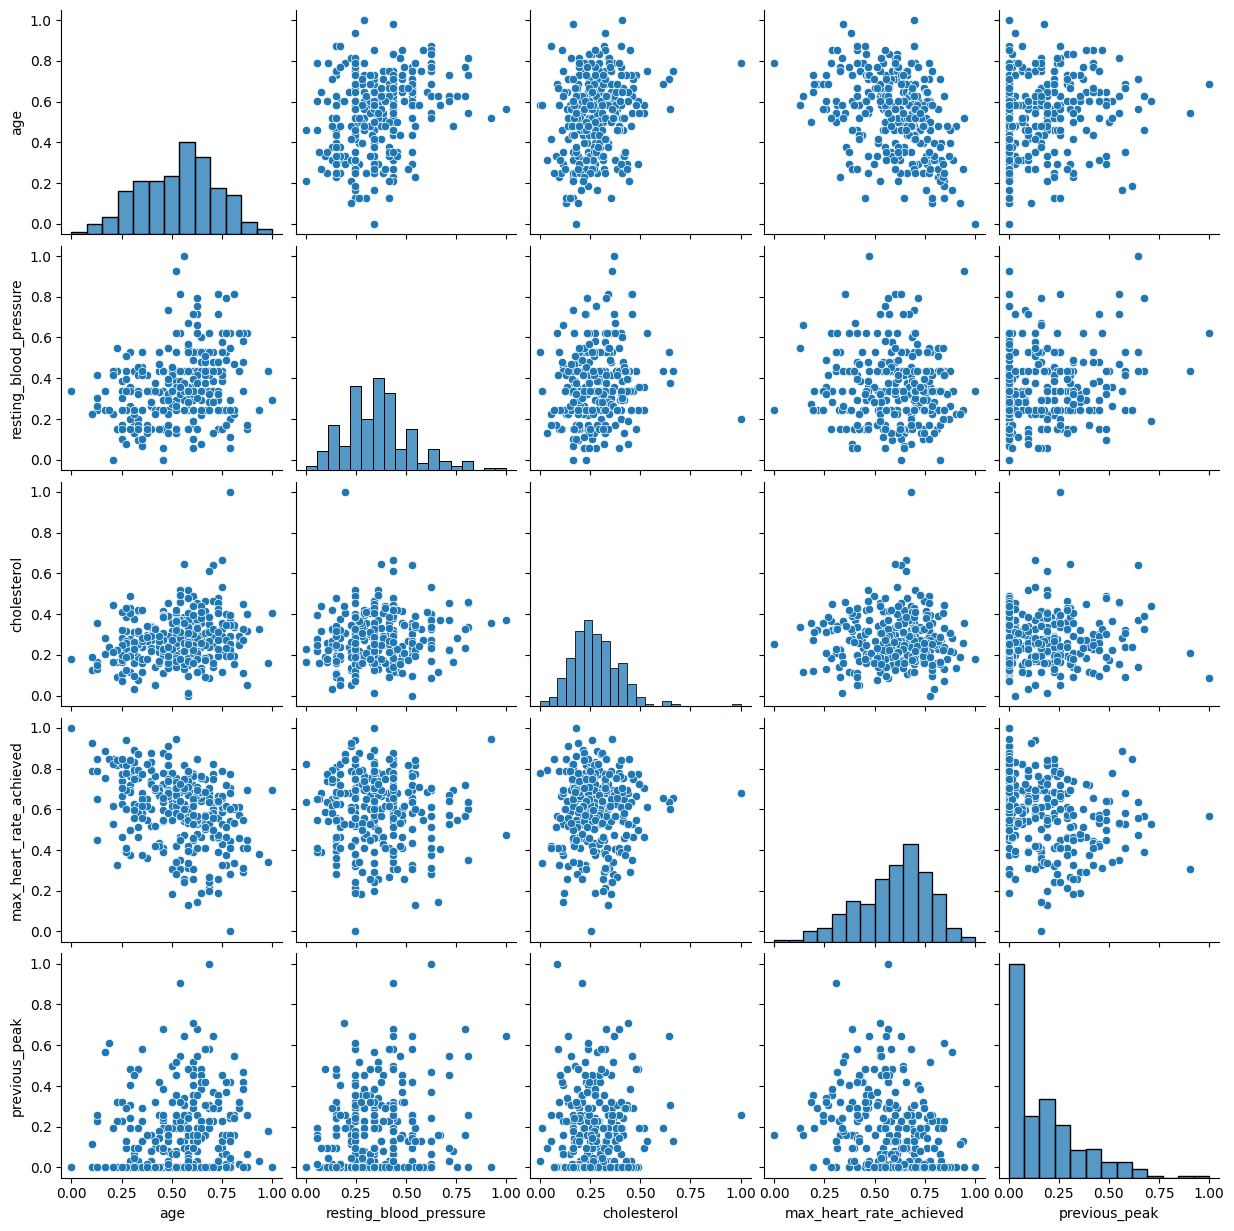

In [11]:
# create a pairplot of continuous variables
continuous_columns = [
    'age',
    'resting_blood_pressure',
    'cholesterol',
    'max_heart_rate_achieved',
    'previous_peak'
]

ax = sns.pairplot(
    heart_attack[continuous_columns]
)

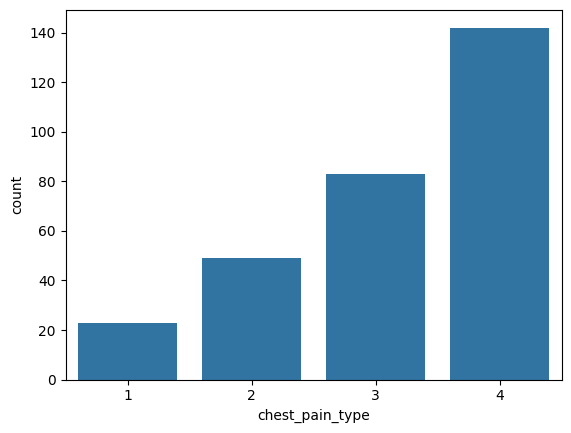

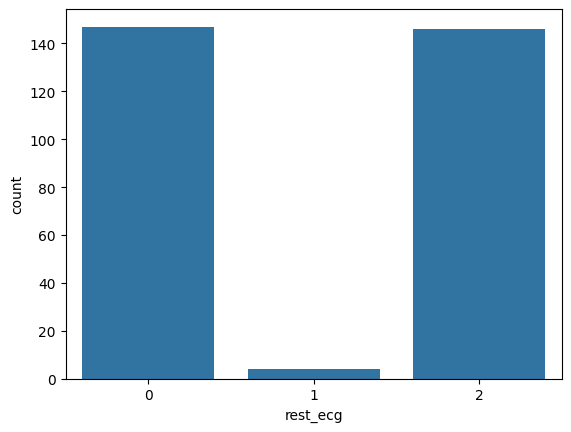

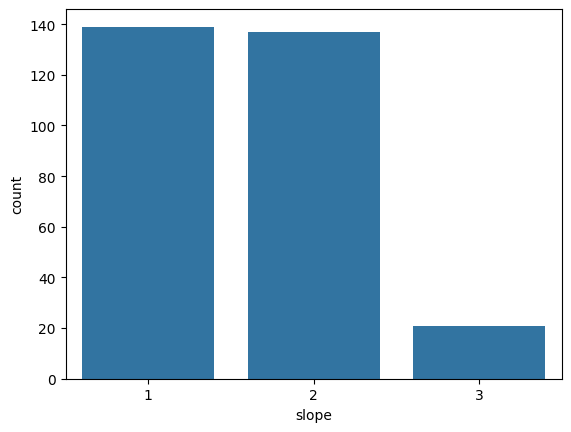

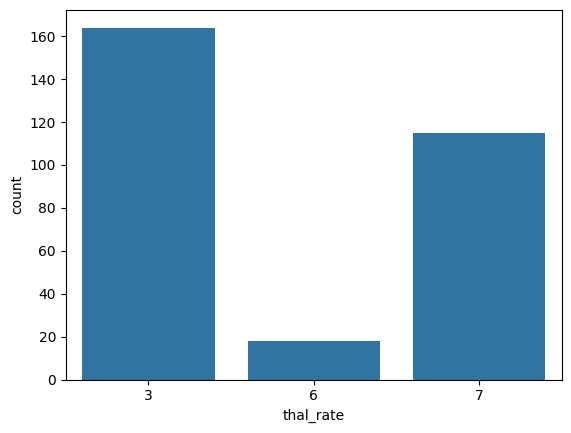

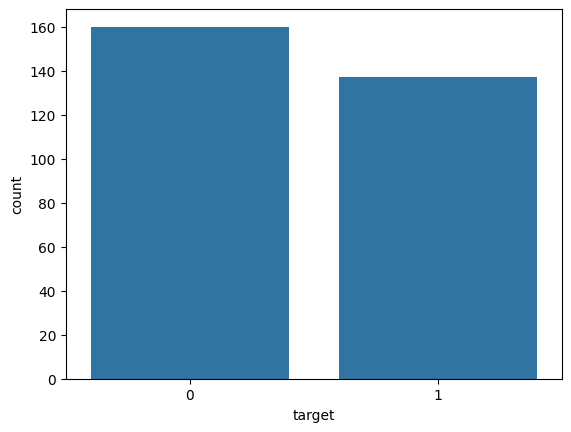

In [12]:
# plot categorical variables as bar plots
categorical_columns = [
    'chest_pain_type',
    'rest_ecg',
    'slope',
    'thal_rate',
    'target'
]

for column in categorical_columns:
    ax = sns.countplot(
        x=column,
        data=heart_attack
    )
    plt.show()

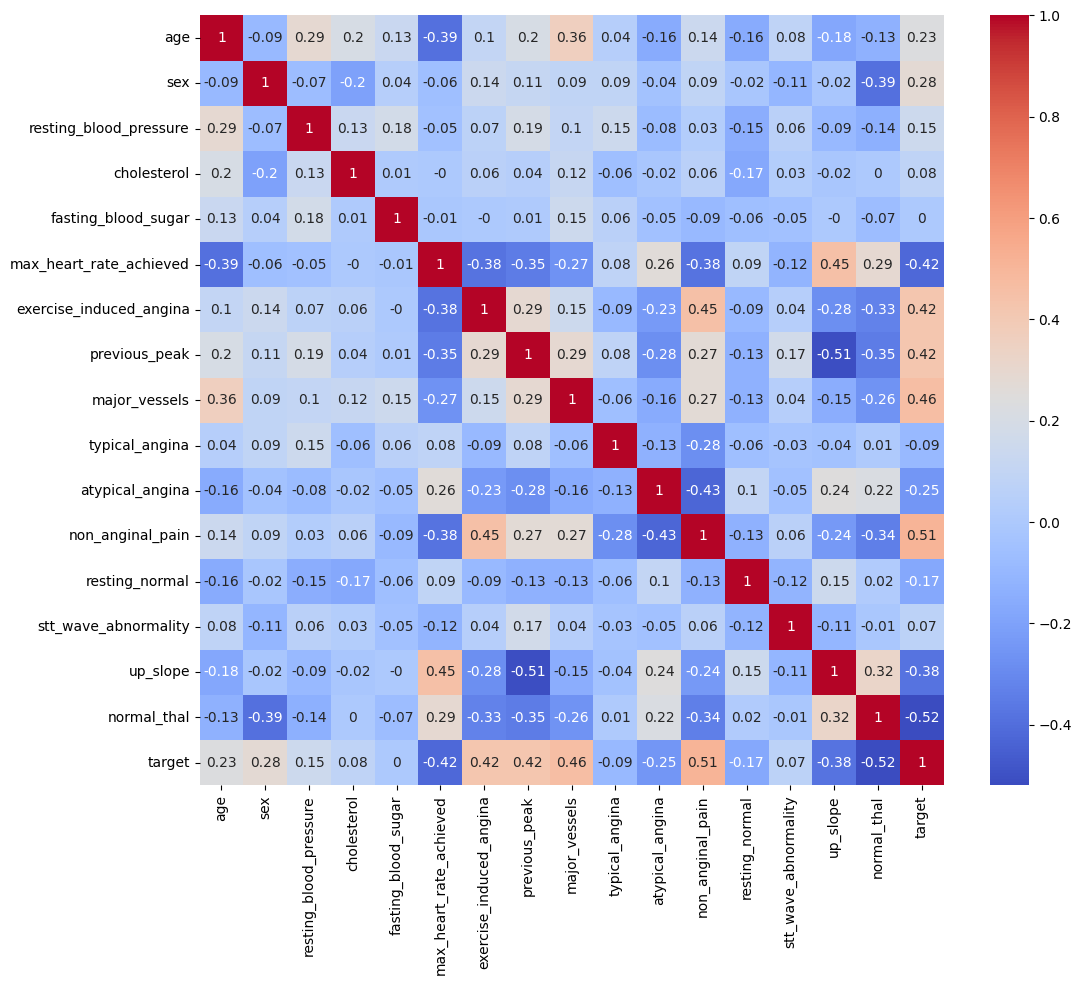

In [13]:
# create a correlation matrix
# exclude the categorical features we converted to binary
correlation_columns_to_exclude = [
    'chest_pain_type',
    'rest_ecg',
    'slope',
    'thal_rate',
    'target_multiclass',
]

correlation_columns = [
    column for column in heart_attack.columns if column not in correlation_columns_to_exclude
]

correlation = heart_attack[correlation_columns].corr().round(2)

ax = sns.heatmap(
    correlation,
    annot=True,
    cmap='coolwarm'
)

fig = ax.get_figure()
fig.set_size_inches(12, 10)

# ax.savefig("plots/correlation.png")

In [14]:
# creating list with the features we will use to train each model
# exclude target columns
# exclude catgorical columns which have been transformed into binary columns
columns_to_drop = [
    'target',
    'target_multiclass',
    'chest_pain_type',
    'rest_ecg',
    'slope',
    'thal_rate',
]

features = [column for column in list(heart_attack.columns) if column not in columns_to_drop]
print(features)


['age', 'sex', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'max_heart_rate_achieved', 'exercise_induced_angina', 'previous_peak', 'major_vessels', 'typical_angina', 'atypical_angina', 'non_anginal_pain', 'resting_normal', 'stt_wave_abnormality', 'up_slope', 'normal_thal']


Through our exploratory data analysis, we see that there is not much correlation between continuous features, so no action is needed to remove correlated features. We also see that some of the features need to be rescaled, and some categorical variables can be simplified and converted to binary variables.

The exploratory data analysis provided insight into the distributions of and relationships between features, which we can use during feature selection. It also informed the data cleaning which occurred earlier in the notebook as part of the iterative process of data analysis.

## Modeling

Now that we have an understanding of what our data looks like and the patterns which exist within it, we can begin to develop models to predict heart disease.

We'll train and tune three models: a logistic regression model, a random forest model, and a support vector machine model.

After the models are trained and tuned, we'll evaluate each and select one to use for our application.

### Logistic Regression

The first model we'll train is a logistic regression.

We'll use forward stepwise feature selection to ensure that our logistic regression model is not impacted by the curse of dimensionality.

In [15]:

# feature selection
# loop through all columns and calculate the accuracy of the model
# add feature which improves the accuracy the most
columns_to_check = features.copy()
accuracy = []
lr_features = []
while len(columns_to_check) > 0:
    # print(columns_to_check)
    best_accuracy = 0
    best_feature = None
    for column in columns_to_check:
        lr = LogisticRegression(solver='liblinear')
        X = heart_attack[lr_features + [column]]
        y = heart_attack['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        lr.fit(X_train, y_train)
        current_accuracy = lr.score(X_test, y_test)
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_feature = column
    # print(best_feature, best_accuracy)
    accuracy.append(best_accuracy)
    lr_features.append(best_feature)
    columns_to_check.remove(best_feature)


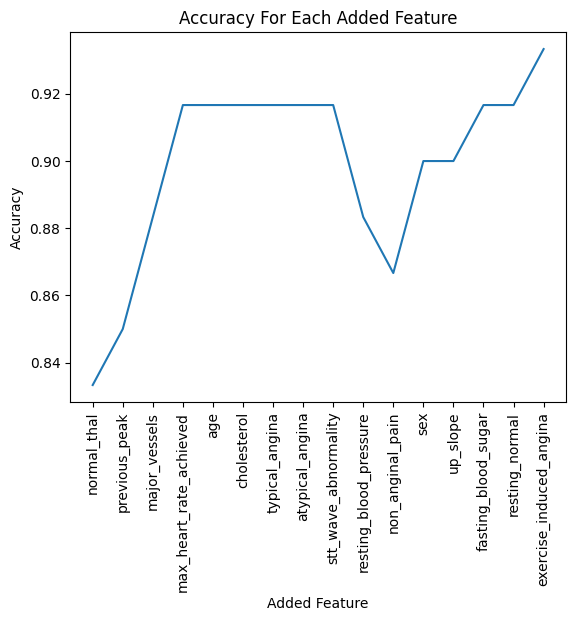

In [16]:
# plot accuracy for each added feature
plt.plot(lr_features, accuracy)
plt.xlabel('Added Feature')
plt.ylabel('Accuracy')
plt.title('Accuracy For Each Added Feature')
plt.xticks(rotation=90)
# plt.savefig("lr_feature_selection.png")
plt.show()

In [17]:
# final lr model
# including all features as it is unclear whether removing any of them would improve the model
lr = LogisticRegression(solver='liblinear')
X = heart_attack[features]
y = heart_attack['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr.fit(X_train, y_train)

# accuracy, precision, recall
y_pred = lr.predict(X_test)
print('Accuracy: {}'.format(round(lr.score(X_test, y_test), 3)))
print('Precision: {}'.format(round(precision_score(y_test, y_pred), 3)))
print('Recall: {}'.format(round(recall_score(y_test, y_pred), 3)))

Accuracy: 0.933
Precision: 0.917
Recall: 0.917


### Random Forest

Next model we'll train is a random forest model.

We'll tune the model by iterating through a few different values of the `n_estimators` and `ccp_alpha` hyperparameters and select the values which maximize the cross-validation accuracy.

In [18]:
# hyperparameter tuning
# loop through different values of n_estimators and ccp_alpha and calculate the accuracy of the model
# choose the best hyperparameters
parameters = {
    'n_estimators': [2 ** i for i in range(1, 9)],
    'ccp_alpha': [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12]
}
rf = RandomForestClassifier(random_state=3)
X = heart_attack[features]
y = heart_attack['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
grid_search = GridSearchCV(rf, parameters, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

{'ccp_alpha': 0.08, 'n_estimators': 16}
0.8271276595744681
RandomForestClassifier(ccp_alpha=0.08, n_estimators=16, random_state=3)


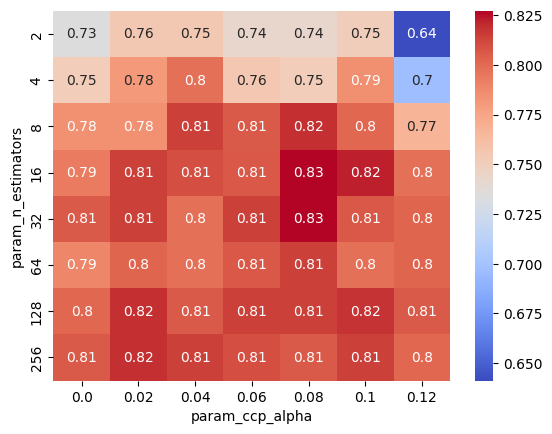

In [19]:
# plot grid search results
results = pd.DataFrame(grid_search.cv_results_)
# print(results)
results = results[['param_n_estimators', 'param_ccp_alpha', 'mean_test_score']]
results['param_n_estimators'] = results['param_n_estimators'].astype(int)
results['param_ccp_alpha'] = results['param_ccp_alpha'].astype(float)
results = results.pivot(index = 'param_n_estimators', columns = 'param_ccp_alpha', values = 'mean_test_score')
ax = sns.heatmap(
    results,
    annot=True,
    cmap='coolwarm'
)
# ax.get_figure().savefig('plots/rf_grid_search.png')

In [20]:
# final rf model
# based on the grid search, it looks like the best hyperparameters are n_estimators=16 and ccp_alpha=0.08. Let's use those!
rf = RandomForestClassifier(n_estimators=16, ccp_alpha=0.08, random_state=3)
X = heart_attack[features]
y = heart_attack['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf.fit(X_train, y_train)

# accuracy, precision, recall
y_pred = rf.predict(X_test)
print('Accuracy: {}'.format(round(rf.score(X_test, y_test), 3)))
print('Precision: {}'.format(round(precision_score(y_test, y_pred), 3)))
print('Recall: {}'.format(round(recall_score(y_test, y_pred), 3)))

Accuracy: 0.883
Precision: 0.87
Recall: 0.833


### SVM

The last model we'll train is a support vector machine model.

We'll use the `rbf` kernel, and we'll tune the model by iterating through a few different values of the `C` and `gamma` hyperparameters and select the values which maximize the cross-validation accuracy. However, we should be careful to not overfit the model!

In [ ]:
# hyperparameter tuning
# loop through different values of C and gamma and calculate the accuracy of the model
# choose the best hyperparameters
parameters = {
    'C': [2 ** i for i in range(-4, 16)],
    'gamma': [10 ** i for i in range(-6, 3)]
}
svm = SVC(kernel='rbf')
X = heart_attack[features]
y = heart_attack['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
grid_search = GridSearchCV(svm, parameters, cv=10)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

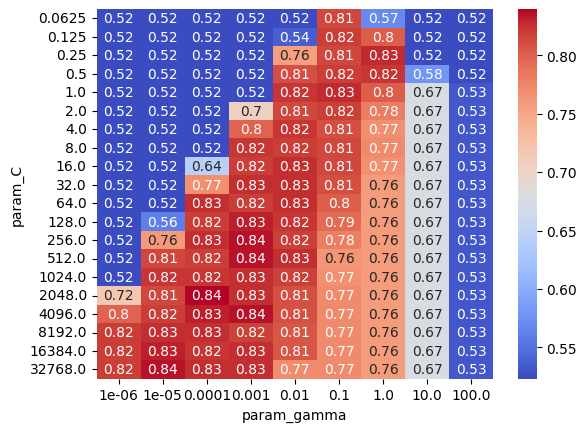

In [ ]:
# plot grid search results
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_C', 'param_gamma', 'mean_test_score']]
results['param_C'] = results['param_C'].astype(float)
results['param_gamma'] = results['param_gamma'].astype(float)
results = results.pivot(index = 'param_C', columns = 'param_gamma', values = 'mean_test_score')
ax = sns.heatmap(
    results,
    annot=True,
    cmap='coolwarm'
)
# ax.get_figure().savefig('plots/svm_grid_search.png')

In [ ]:
# final svm model
# based on the grid search and the heatmap, we will use C=1 and gamma=0.1
# that way, the model will be less likely to overfit
svm = SVC(C=1, gamma=0.1)
X = heart_attack[features]
y = heart_attack['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svm.fit(X_train, y_train)

# accuracy, precision, recall
y_pred = svm.predict(X_test)
print('Accuracy: {}'.format(round(svm.score(X_test, y_test), 3)))
print('Precision: {}'.format(round(precision_score(y_test, y_pred), 3)))
print('Recall: {}'.format(round(recall_score(y_test, y_pred), 3)))

Accuracy: 0.883
Precision: 0.905
Recall: 0.792


## Model Comparison

Now that we have each of our three models trained and tuned, we will compare them and select one to use for our application.

In order to compare each model, we will plot the ROC curve of each, inspect their accuracy, precision and recall metrics, and evaluate their confusion matrices.

We'll also consider the functionality of each model.

In [ ]:
# printing accuracy, precision, recall and confusion matrix for each model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# logistic regression
y_pred = lr.predict(X_test)
print('Logistic Regression')
print('Accuracy: {}'.format(round(lr.score(X_test, y_test), 3)))
print('Precision: {}'.format(round(precision_score(y_test, y_pred), 3)))
print('Recall: {}'.format(round(recall_score(y_test, y_pred), 3)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test, y_pred)))
print('\n')

# random forest
y_pred = rf.predict(X_test)
print('Random Forest')
print('Accuracy: {}'.format(round(rf.score(X_test, y_test), 3)))
print('Precision: {}'.format(round(precision_score(y_test, y_pred), 3)))
print('Recall: {}'.format(round(recall_score(y_test, y_pred), 3)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test, y_pred)))
print('\n')

# support vector machine
y_pred = svm.predict(X_test)
print('Support Vector Machine')
print('Accuracy: {}'.format(round(svm.score(X_test, y_test), 3)))
print('Precision: {}'.format(round(precision_score(y_test, y_pred), 3)))
print('Recall: {}'.format(round(recall_score(y_test, y_pred), 3)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test, y_pred)))

Logistic Regression
Accuracy: 0.933
Precision: 0.917
Recall: 0.917
Confusion Matrix:
[[34  2]
 [ 2 22]]


Random Forest
Accuracy: 0.883
Precision: 0.87
Recall: 0.833
Confusion Matrix:
[[33  3]
 [ 4 20]]


Support Vector Machine
Accuracy: 0.883
Precision: 0.905
Recall: 0.792
Confusion Matrix:
[[34  2]
 [ 5 19]]


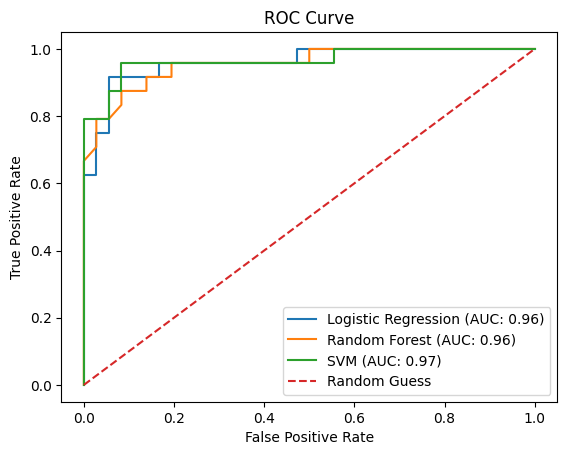

In [ ]:
# roc curve for all models

# logistic regression
y_pred = lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
lr_auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr)

# random forest
y_pred = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
rf_auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr)

# svm
y_pred = svm.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
svm_auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend([
    f'Logistic Regression (AUC: {lr_auc:.2f})',
    f'Random Forest (AUC: {rf_auc:.2f})',
    f'SVM (AUC: {svm_auc:.2f})',
    'Random Guess'
])
# plt.savefig('plots/roc_curve.png')

After inspecting the accuracy, precision and recall metrics and evaluating the ROC curve and the confusion matrices of each model, it appears that the logistic regression model performs the best. The logistic regression model achieves the highest accuracy, precision and recall of the three models, with an accuracy score of 0.933. It also maintains a high AUC of 0.96. However, the random forest and SVM models also perform well. The random forest achieves an accuracy of 0.883 and an AUC of 0.96, while the SVM achieves and accuracy of 0.883 and an AUC of 0.97. Since the performance of all three models is similar, it is possible that there is not significant difference in performance when given new data.

However, the logistic regression model also provides interpretable results and can produce predicted probabilities, which we can implement into our application. It is also a fairly simple model and can quickly calculate prdictions. As such, we will use the logistic regression model in our application due to the potential accuracy gains and its interpretability.

## Conclusion

We have successfully developed a machine learning model which can be used to predict heart disease in an individual! The logistic regression model we developed achieved an accuracy of 0.933, precision of 0.917, and recall of 0.917. It can also be used to return the predicted probability that an individual has heart disease.

There are a few improvements which can be made in future iterations of this project. One improvement is to tune additonal hyperparameters for each of the three models. Additional tuning might result in further increases in model accuracy. Another improvement is to re-examine the metrics which these models are being optimized for. Perhaps it is more important that all heart disease patients are flagged by our model. In this case, we would retrain each model and tune it to optimize for recall rather than accuracy. This decision should be made by consulting with medical prefessionals as subject matter experts.

### Demo

Now that we have chosen a model, let's do a quick demo!

We'll generate some fake data, feed it to the trained model, and observe the results.

In [ ]:
# generate sample data for demonstration
# print(heart_attack[features].iloc[0].to_list())
# print(heart_attack[features].iloc[1].to_list())

demo_data = [
    0.8, # age
    1, # sex
    0.6, # resting_blood_pressure
    0.7, # cholesterol
    1, # fasting_blood_sugar
    0.2, # max_heart_rate_achieved
    0, # exercise_induced_angina
    0.2, # previous_peak
    3, # major_vessels
    0, # typical_angina
    1, # atypical_angina
    0, # non_anginal_pain
    1, # resting_normal
    0, # stt_wave_abnormality
    1, # up_slope
    0, # normal_thal
]

print('Predicted Category: {}'.format('Heart Disease' if lr.predict([demo_data])[0] == 1 else 'No Heart Disease'))
print('Predicted Probability of Heart Disease: {}'.format(round(lr.predict_proba([demo_data])[:, 1][0], 3)))

Predicted Category: Heart Disease
Predicted Probability of Heart Disease: 0.935


/Users/kevin.katzmann/.pyenv/versions/data_science/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/kevin.katzmann/.pyenv/versions/data_science/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
